<a href="https://colab.research.google.com/github/niteshctrl/mnist-under-10k-parameters/blob/main/mnist.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. Introduction

The MNIST database of handwritten digits, available from this page, has a training set of 60,000 examples, and a test set of 10,000 examples. It is a subset of a larger set available from NIST. The digits have been size-normalized and centered in a fixed-size image.

The aim is to achieve 99.4% accuracy under 10K parameters.


## Importing Libraries

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import BatchNormalization


#Visualization Libraries

import seaborn as sns
import matplotlib.pyplot as plt

# 2. EDA & Data Preparation

## Importing Dataset

In [ ]:
(X_train, y_train), (X_test, y_test) = keras.datasets.mnist.load_data()

## Analysing the Data

In [ ]:
# Shapes of training and test data

print("Shape of Train data(X_train) = {} and labels(y_train) = {}".format(X_train.shape, y_train.shape))
print("Shape of Test data(X_test) = {} and test labels(y_test) = {}".format(X_test.shape, y_test.shape))


Shape of Train data(X_train) = (60000, 28, 28) and labels(y_train) = (60000,)
Shape of Test data(X_test) = (10000, 28, 28) and test labels(y_test) = (10000,)


## Distribution of Output Labels

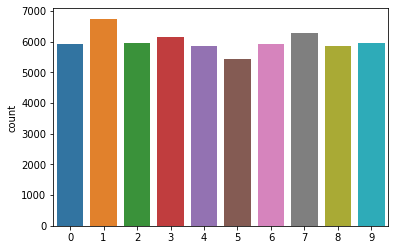

In [ ]:
# Distribution of Train data

sns.countplot(x=y_train)
plt.show()

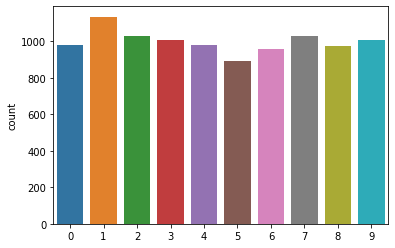

In [ ]:
# Distribution of Test data

sns.countplot(x=y_test)
plt.show()

## Visualising a few input data

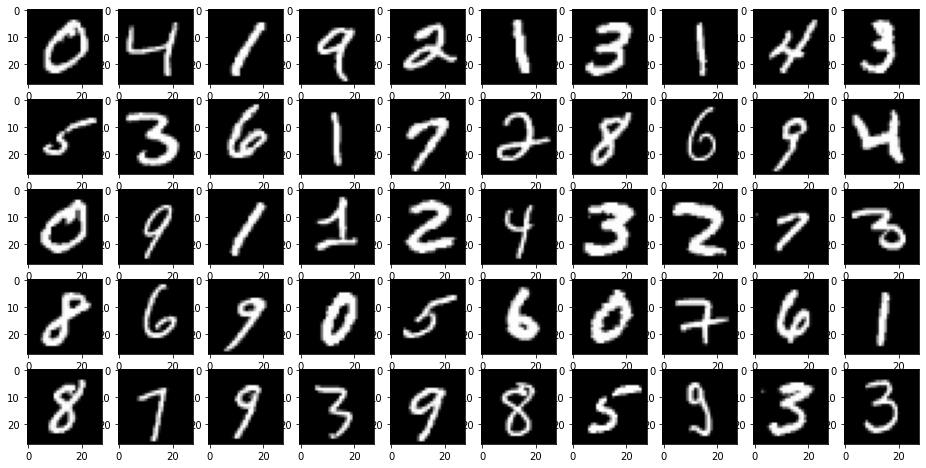

In [ ]:
fig=plt.figure(figsize=(16, 8))
columns = 10
rows = 5
for i in range(1, columns*rows +1):
    img = X_train[i]
    fig.add_subplot(rows, columns, i)
    plt.imshow(img,cmap='gray')
plt.show()

## Preprocessing Data

In [ ]:
X_new = (x - min(x)) / {max(x) - min(x)}

In [ ]:
# Normalizing Inputs

X_train = X_train.reshape(60000, 28, 28, 1)
X_test = X_test.reshape(10000, 28, 28, 1)
X_train = X_train / 255.0
X_test = X_test / 255.0

# One-Hot Encoding the Output labels

y_train = keras.utils.to_categorical(y_train, num_classes=10)
y_test = keras.utils.to_categorical(y_test, num_classes=10)

## Data Augmentation



In [ ]:
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images

datagen.fit(X_train)

# 3. Modelling

## CNN Model

In [ ]:
model_cnn = tf.keras.Sequential([
                Conv2D(2, (3,3), activation=tf.nn.relu, input_shape=(28,28,1), 
                       padding='same'),
                Conv2D(4, (3,3), activation=tf.nn.relu, padding='same', 
                       kernel_initializer="he_normal"),
                BatchNormalization(),
                Conv2D(8, (3,3), activation=tf.nn.relu, padding='same', 
                       kernel_initializer="he_normal"),
                MaxPooling2D(),
                BatchNormalization(),
                Conv2D(16, (3,3), activation=tf.nn.relu, padding='same', 
                       kernel_initializer="he_normal"),
                MaxPooling2D(),
                BatchNormalization(),
                Conv2D(32, (3,3), activation=tf.nn.relu, padding='same', 
                       kernel_initializer="he_normal"),                        
                MaxPooling2D(),
                BatchNormalization(),
                tf.keras.layers.Flatten(),
                tf.keras.layers.Dense(10, activation=tf.nn.softmax)
])

model_cnn.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_10 (Conv2D)           (None, 28, 28, 2)         20        
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 28, 28, 4)         76        
_________________________________________________________________
batch_normalization_10 (Batc (None, 28, 28, 4)         16        
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 28, 28, 8)         296       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 14, 14, 8)         0         
_________________________________________________________________
batch_normalization_11 (Batc (None, 14, 14, 8)         32        
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 14, 14, 16)       

*   ReLU activations have been used in the hidden layers and softmax in the output layer.
*   Kernel Initializer Used = "He Normal"
* Max Pooling layers have been used to decrease the image size simultaneously with increase in number of kernels so as to retain the essential features.
* Batch Normalization has been used at each convutional layer to avoid vanishing gradiient problem; though it is more prominent in deep neural network and this is faily shallow net.



In [ ]:
_learning_rate = 0.001

In [ ]:
model_cnn.compile(optimizer=keras.optimizers.Adam(_learning_rate), 
                  loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epochs, logs={}):
        if(logs.get('val_accuracy') > 0.994):
            self.model.stop_training = True

def lr_scheduler(epoch):
    pass # TBD

callbacks = myCallback()

In [ ]:
history = model_cnn.fit(datagen.flow(X_train,y_train, batch_size=32),
                epochs = 20, validation_data = (X_test,y_test), 
                callbacks=[callbacks])

Epoch 1/20
1875/1875 [==============================] - 19s 10ms/step - loss: 0.5878 - accuracy: 0.8125 - val_loss: 0.1034 - val_accuracy: 0.9676
Epoch 2/20
1875/1875 [==============================] - 18s 10ms/step - loss: 0.0950 - accuracy: 0.9710 - val_loss: 0.0447 - val_accuracy: 0.9862
Epoch 3/20
1875/1875 [==============================] - 18s 10ms/step - loss: 0.0711 - accuracy: 0.9782 - val_loss: 0.0613 - val_accuracy: 0.9798
Epoch 4/20
1875/1875 [==============================] - 18s 10ms/step - loss: 0.0636 - accuracy: 0.9803 - val_loss: 0.0402 - val_accuracy: 0.9877
Epoch 5/20
1875/1875 [==============================] - 19s 10ms/step - loss: 0.0598 - accuracy: 0.9819 - val_loss: 0.0476 - val_accuracy: 0.9848
Epoch 6/20
1875/1875 [==============================] - 18s 10ms/step - loss: 0.0503 - accuracy: 0.9836 - val_loss: 0.0390 - val_accuracy: 0.9874
Epoch 7/20
1875/1875 [==============================] - 18s 10ms/step - loss: 0.0481 - accuracy: 0.9854 - val_loss: 0.0616 -

In [ ]:
history1 = history

In [ ]:
_learning_rate = 0.0001

model_cnn.compile(optimizer=keras.optimizers.Adam(_learning_rate), 
                  loss='categorical_crossentropy', metrics=['accuracy'])

history = model_cnn.fit(datagen.flow(X_train,y_train, batch_size=32),
                epochs = 20, validation_data = (X_test,y_test), 
                callbacks=[callbacks])

Epoch 1/20
1875/1875 [==============================] - 19s 10ms/step - loss: 0.0286 - accuracy: 0.9905 - val_loss: 0.0172 - val_accuracy: 0.9942


# 4. Evaluation

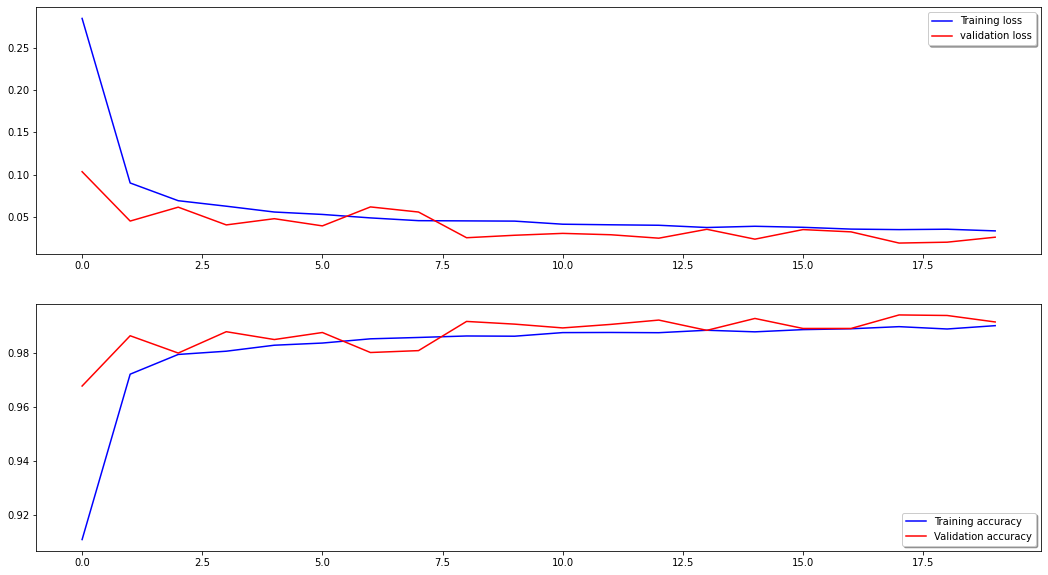

In [ ]:
# Plot train and validation loss

# Plot the loss and accuracy curves for training and validation 
fig, ax = plt.subplots(2,1, figsize=(18, 10))
ax[0].plot(history1.history['loss'], color='b', label="Training loss")
ax[0].plot(history1.history['val_loss'], color='r', label="validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history1.history['accuracy'], color='b', label="Training accuracy")
ax[1].plot(history1.history['val_accuracy'], color='r',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)

In [ ]:
print("\n \nAccuracy on Test Set = {0:.2f}%".format(model_cnn.evaluate(X_test, y_test)[1]*100))

313/313 [==============================] - 1s 2ms/step - loss: 0.0172 - accuracy: 0.9942

 
Accuracy on Test Set = 99.42%


# 5. Results and Summary

A test accuracy of 99.42% is achieved using 9330 parameters(9210 trainable and 120 non-trainable). 

Corresponding train accuracy being 99.05% denotes the model has not overfit and has generalized better. A learning rate of 0.001 was initially used for 20 epochs which asymptotically stuck the accuracy to less than 99.4%. Hence reducing the rate by a factor of 10, gave the desired result in the very first epoch thereafter which training was stopped by the callback. Optimizer used was ADAM alongwith the default batch size of 32 datapoints. 

On the model architecture:
* ReLU activations have been used in the hidden layers and softmax in the output layer.
* Kernel Initializer Used = "He Normal"
* Max Pooling layers have been used to decrease the image size simultaneously with increase in number of kernels so as to retain the essential features.
* Batch Normalization has been used at each convutional layer to avoid vanishing gradiient problem; though it is more prominent in deep neural network and this is faily shallow net.


Data augmentation has been used which significantly enhanced the generalized accuracy. Prior to this, it was stuck below 99.2% with the same set of model's hyperparameters. The parameters used for augmentation are:
* rotation_range of 10 which randomly rotates images in the range  0 to 10 degrees.
* zoom_range = 0.1 which randomly zooms images by 10%.
* width_shift_range=0.1 which randomly shifts images horizontally by 10% and  height_shift_range=0.1.


The data was distributred near to uniform among the 10 labels in both train and test data and hence no much work was required here.

The accuracy can be further enhanced for under 10K parameters as I still have ~700 parameters to play with and training has been made to halt at 99.4% accuracy as further improvement is beyond the scope of this notebook as of now. 

#6. References

* [Introduction to CNN Keras - 0.997 (top 6%)] https://www.kaggle.com/yassineghouzam/introduction-to-cnn-keras-0-997-top-6

* [MNIST: Simple CNN keras (Accuracy : 0.99)=>Top 1%] https://www.kaggle.com/elcaiseri/mnist-simple-cnn-keras-accuracy-0-99-top-1

* [MNIST digit classification - 99.5% accuracy] https://www.kaggle.com/anmolkumar/mnist-digit-classification-99-5-accuracy

* [MNIST Chalenge] https://github.com/aknakshay/MNIST-Challenge/blob/master/MNIST_Challenge.ipynb